In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the complete dataset with all features
print("Loading the dataset with all features...")
dataset = pd.read_csv("final_dataset_with_all_features.csv")
print(f"Dataset shape: {dataset.shape}")

# Display basic info about the dataset
print("\nBasic dataset information:")
print(f"Number of features: {dataset.shape[1]}")
print(f"Number of samples: {dataset.shape[0]}")

# Check class distribution to confirm imbalance
class_distribution = dataset['label'].value_counts()
print("\nClass distribution:")
print(class_distribution)
print(f"Percentage of majority class: {100 * class_distribution.max() / len(dataset):.2f}%")

Loading the dataset with all features...
Dataset shape: (2035, 33)

Basic dataset information:
Number of features: 33
Number of samples: 2035

Class distribution:
label
Fake    1281
Real     754
Name: count, dtype: int64
Percentage of majority class: 62.95%


In [2]:
dataset.head()

,author,title,text,site_url,label,language,enhanced_source_credibility_score,enhanced_author_credibility_score,title_length_of_characters,title_word_count,...,title_emotional_charged_words_count,text_emotional_charged_words_count,weighted_title_sensationalism_density,weighted_text_sensationalism_density,sentiment_compound_score,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_category,sentiment_intensity
0,Barracuda Brigade,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,100percentfedup.com,Real,english,95.28177,85.755236,51,8,...,0,0,0.000000,0.000000,0.1027,0.106,0.092,0.802,Positive,Weak
1,reasoning with facts,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,100percentfedup.com,Real,english,95.28177,82.226429,57,10,...,0,0,0.000000,0.000000,-0.9217,0.038,0.087,0.875,Negative,Very Strong
2,Barracuda Brigade,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,100percentfedup.com,Real,english,95.28177,85.755236,67,9,...,0,0,0.000000,0.007976,0.9135,0.090,0.026,0.884,Positive,Very Strong
3,Fed Up,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,100percentfedup.com,Real,english,95.28177,88.238767,115,20,...,0,1,0.000000,0.051603,0.1667,0.267,0.242,0.490,Positive,Weak
4,Fed Up,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,100percentfedup.com,Real,english,95.28177,88.238767,90,12,...,1,0,0.188136,0.009236,0.9467,0.125,0.085,0.790,Positive,Very Strong


In [6]:
print(f"Dataset shape: {dataset.shape}")

Dataset shape: (2035, 33)


In [3]:
# Separate features and target
print("\nPreparing features and target...")

# Create a list of features to be used for feature importance calculation
# We exclude text columns from feature importance calculation, but keep them in the dataset
feature_columns = [col for col in dataset.columns if col not in ['author', 'title', 'text', 'site_url', 'label', 'language']]

# Check for categorical features among the feature columns
categorical_columns = []
for col in feature_columns:
    # Check if column contains non-numeric data
    if dataset[col].dtype == 'object':
        categorical_columns.append(col)

print(f"\nCategorical columns that need encoding: {categorical_columns}")


Preparing features and target...

Categorical columns that need encoding: ['sentiment_category', 'sentiment_intensity']


In [4]:
# Create a copy of the dataset for modeling purposes
modeling_data = dataset.copy()

# Encode categorical features
print("\nEncoding categorical features...")
for col in categorical_columns:
    # Use LabelEncoder for nominal categorical variables
    le = LabelEncoder()
    modeling_data[col] = le.fit_transform(modeling_data[col])

# Extract features for importance calculation
X_for_importance = modeling_data[feature_columns]
y = (modeling_data['label'] == 'Real').astype(int)  # Convert target to binary format (0 for Fake, 1 for Real)

# Split the data into training, validation, and test sets with stratification
# First split: 80% training+validation, 20% test
X_temp, X_test, y_temp, y_test, indices_temp, indices_test = train_test_split(
    X_for_importance, y, np.arange(len(y)), test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% training, 25% validation (resulting in 60% train, 20% validation, 20% test overall)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_temp, y_temp, indices_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("\nData split sizes:")
print(f"Training set: {X_train.shape[0]} samples ({100 * X_train.shape[0] / len(X_for_importance):.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({100 * X_val.shape[0] / len(X_for_importance):.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({100 * X_test.shape[0] / len(X_for_importance):.1f}%)")

# Check class distribution in each split
print("\nClass distribution in each split:")
print(f"Training set - Percentage of Real: {100 * y_train.mean():.2f}%")
print(f"Validation set - Percentage of Real: {100 * y_val.mean():.2f}%")
print(f"Test set - Percentage of Real: {100 * y_test.mean():.2f}%")


Encoding categorical features...

Data split sizes:
Training set: 1221 samples (60.0%)
Validation set: 407 samples (20.0%)
Test set: 407 samples (20.0%)

Class distribution in each split:
Training set - Percentage of Real: 37.02%
Validation set - Percentage of Real: 37.10%
Test set - Percentage of Real: 37.10%



Performing feature selection using Random Forest feature importance...

Top 19 most important features:
                                Feature  Importance
0     enhanced_source_credibility_score    0.551463
1     enhanced_author_credibility_score    0.324894
6              text_average_word_length    0.014620
12      text_average_word_length_zscore    0.012782
5                       text_word_count    0.008230
21             sentiment_compound_score    0.007609
7          text_average_sentence_length    0.007354
13  text_average_sentence_length_zscore    0.007153
11               text_word_count_zscore    0.006927
10     text_length_of_characters_zscore    0.006923
4             text_length_of_characters    0.006746
8     title_length_of_characters_zscore    0.006335
2            title_length_of_characters    0.005954
23             sentiment_negative_score    0.005208
22             sentiment_positive_score    0.005008
24              sentiment_neutral_score    0.003745
9          

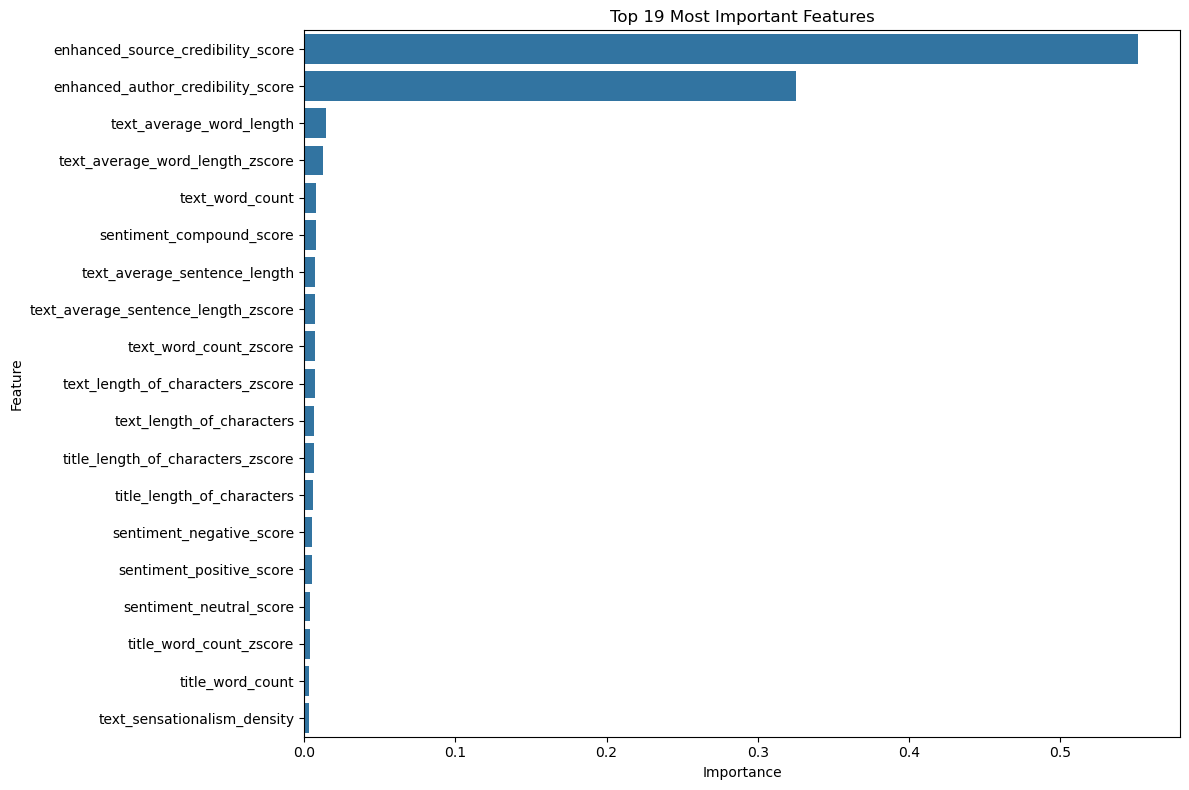

In [10]:
# Feature selection using Random Forest feature importance
print("\nPerforming feature selection using Random Forest feature importance...")

# Initialize and train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Display the top 20 most important features
print("\nTop 19 most important features:")
print(feature_importance_df.head(19))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(19))
plt.title('Top 19 Most Important Features')
plt.tight_layout()
plt.show()


Selecting top 19 features based on importance scores...

Number of selected features: 19 out of 27

Selected features:
- enhanced_source_credibility_score (Importance: 0.5515)
- enhanced_author_credibility_score (Importance: 0.3249)
- title_length_of_characters (Importance: 0.0060)
- title_word_count (Importance: 0.0035)
- text_length_of_characters (Importance: 0.0067)
- text_word_count (Importance: 0.0082)
- text_average_word_length (Importance: 0.0146)
- text_average_sentence_length (Importance: 0.0074)
- title_length_of_characters_zscore (Importance: 0.0063)
- title_word_count_zscore (Importance: 0.0036)
- text_length_of_characters_zscore (Importance: 0.0069)
- text_word_count_zscore (Importance: 0.0069)
- text_average_word_length_zscore (Importance: 0.0128)
- text_average_sentence_length_zscore (Importance: 0.0072)
- text_sensationalism_density (Importance: 0.0033)
- sentiment_compound_score (Importance: 0.0076)
- sentiment_positive_score (Importance: 0.0050)
- sentiment_negative_

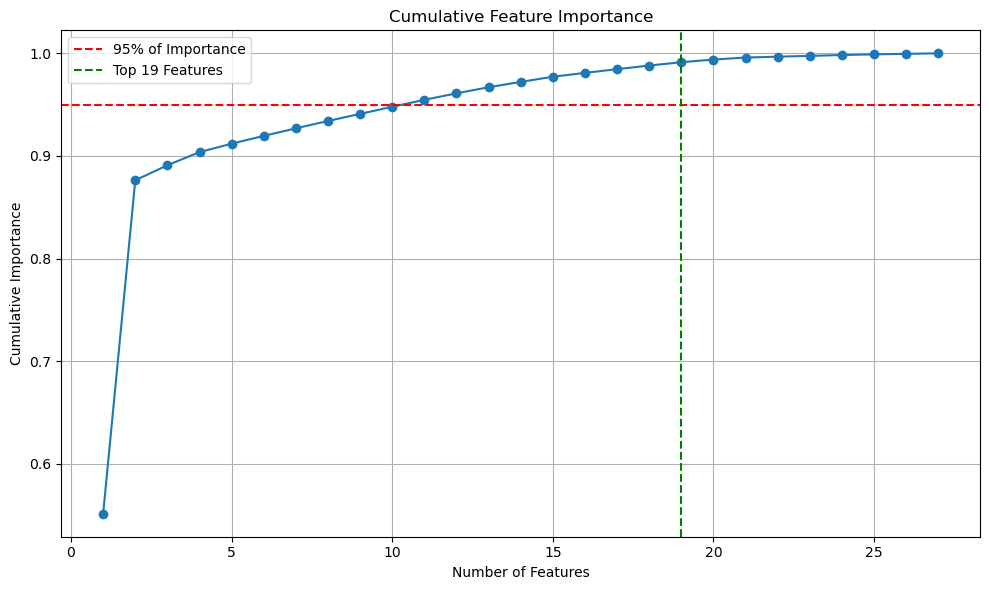

In [13]:
# Instead of using the mean threshold, we'll explicitly select the top 19 features
# This gives us more control over feature selection when some features have very high importance
print("\nSelecting top 19 features based on importance scores...")
top_n_features = 19  # You can adjust this number as needed

# Get the top N feature names
top_features = feature_importance_df.head(top_n_features)['Feature'].tolist()

# Create a boolean mask matching the original order
selected_features_mask = np.array([col in top_features for col in X_train.columns])

# Select the top features from our datasets
X_train_selected = X_train.iloc[:, selected_features_mask].values
X_val_selected = X_val.iloc[:, selected_features_mask].values
X_test_selected = X_test.iloc[:, selected_features_mask].values

# Get the selected feature names in their original order
selected_features = X_train.columns[selected_features_mask].tolist()

print(f"\nNumber of selected features: {len(selected_features)} out of {X_train.shape[1]}")
print("\nSelected features:")
for feature in selected_features:
    importance = feature_importance_df[feature_importance_df['Feature'] == feature]['Importance'].values[0]
    print(f"- {feature} (Importance: {importance:.4f})")

# Also create a cumulative importance plot
plt.figure(figsize=(10, 6))
cumulative_importance = np.cumsum(feature_importance_df['Importance'])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% of Importance')
plt.axvline(x=top_n_features, color='g', linestyle='--', label=f'Top {top_n_features} Features')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Addressing class imbalance in the training set...

Class distribution after resampling:
Original training set - Percentage of Real: 37.02%
Resampled training set - Percentage of Real: 50.00%
Original training samples: 1221
Resampled training samples: 1538
Synthetic samples added: 317

Verifying effectiveness of resampling and feature selection...

Classification report on validation set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       256
           1       1.00      0.98      0.99       151

    accuracy                           0.99       407
   macro avg       0.99      0.99      0.99       407
weighted avg       0.99      0.99      0.99       407



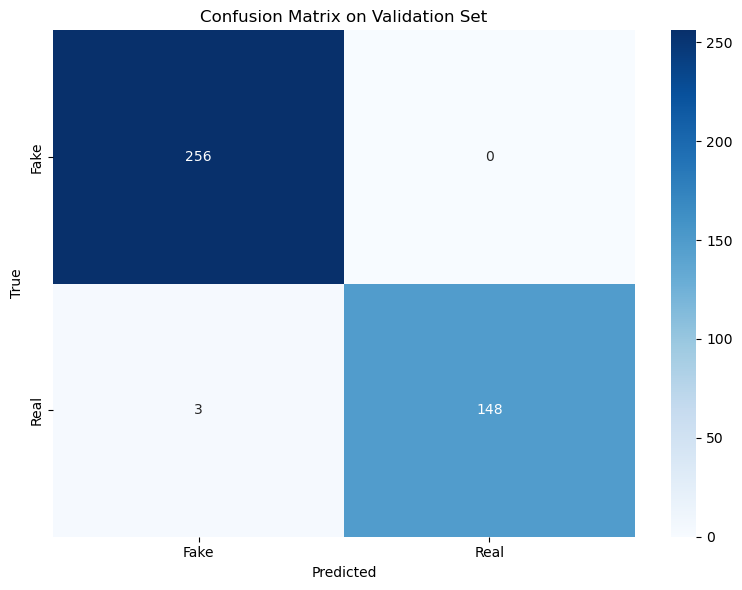

In [14]:
# Address class imbalance in the training set using RandomOverSampler
print("\nAddressing class imbalance in the training set...")
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_selected, y_train)

# Get the indices of the original and new samples
resampled_indices = ros.sample_indices_
synthetic_sample_count = len(y_train_resampled) - len(y_train)

# Check the new class distribution in the resampled training set
print("\nClass distribution after resampling:")
print(f"Original training set - Percentage of Real: {100 * y_train.mean():.2f}%")
print(f"Resampled training set - Percentage of Real: {100 * y_train_resampled.mean():.2f}%")
print(f"Original training samples: {len(y_train)}")
print(f"Resampled training samples: {len(y_train_resampled)}")
print(f"Synthetic samples added: {synthetic_sample_count}")

# Fit a model on the resampled data to verify effectiveness
print("\nVerifying effectiveness of resampling and feature selection...")
rf_test = RandomForestClassifier(n_estimators=50, random_state=42)
rf_test.fit(X_train_resampled, y_train_resampled)

# Evaluate on validation set
y_val_pred = rf_test.predict(X_val_selected)
print("\nClassification report on validation set:")
print(classification_report(y_val, y_val_pred))

# Create a confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Validation Set')
plt.tight_layout()
plt.show()

In [ ]:
# Create datasets that include ALL columns (including text) but use our splits
train_full = dataset.iloc[indices_train].copy()
val_full = dataset.iloc[indices_val].copy()  
test_full = dataset.iloc[indices_test].copy()

# Save the training, validation and test datasets with all columns (including text)
print("\nSaving full datasets (with text columns) based on our splits...")
train_full.to_csv('train_dataset_with_text.csv', index=False)
val_full.to_csv('val_dataset_with_text.csv', index=False)
test_full.to_csv('test_dataset_with_text.csv', index=False)

# Create a properly balanced version of the training dataset
print("\nCreating balanced training dataset with text for BERT...")

# Check current class distribution in training set
real_indices = train_full[train_full['label'] == 'Real'].index.tolist()
fake_indices = train_full[train_full['label'] == 'Fake'].index.tolist()

print(f"Original class distribution - Real: {len(real_indices)}, Fake: {len(fake_indices)}")

# Determine which class is the minority class
if len(real_indices) < len(fake_indices):
    minority_class = 'Real'
    minority_indices = real_indices
    majority_count = len(fake_indices)
else:
    minority_class = 'Fake'
    minority_indices = fake_indices
    majority_count = len(real_indices)

print(f"Minority class: {minority_class} with {len(minority_indices)} samples")
print(f"Need to add {majority_count - len(minority_indices)} samples to balance classes")

# Calculate how many samples to duplicate from the minority class
samples_to_add = majority_count - len(minority_indices)

# Randomly select indices to duplicate (with replacement)
np.random.seed(42)  # For reproducibility
duplicate_indices = np.random.choice(minority_indices, size=samples_to_add, replace=True)

# Create the balanced training dataset
balanced_train_full = train_full.copy()
duplicates = dataset.loc[duplicate_indices].copy()
balanced_train_full = pd.concat([balanced_train_full, duplicates], ignore_index=True)

# Check class distribution in the balanced dataset
balanced_class_dist = balanced_train_full['label'].value_counts()
print("\nBalanced training dataset class distribution:")
print(balanced_class_dist)
print(f"Percentage of majority class: {100 * balanced_class_dist.max() / len(balanced_train_full):.2f}%")
print(f"Percentage of minority class: {100 * balanced_class_dist.min() / len(balanced_train_full):.2f}%")

# Display a few examples from the balanced dataset
print("\nSample rows from balanced training dataset:")
print(balanced_train_full[['label', 'title']].sample(5))

# Check balance more precisely
print("\nVerifying exact balance:")
real_count = (balanced_train_full['label'] == 'Real').sum()
fake_count = (balanced_train_full['label'] == 'Fake').sum()
print(f"Real: {real_count}, Fake: {fake_count}")
print(f"Balance ratio (minority/majority): {min(real_count, fake_count) / max(real_count, fake_count):.4f}")

# Save the balanced training dataset
balanced_train_full.to_csv('balanced_train_dataset_with_text.csv', index=False)



Saving full datasets (with text columns) based on our splits...

Creating balanced training dataset with text for BERT...
Original class distribution - Real: 452, Fake: 769
Minority class: Real with 452 samples
Need to add 317 samples to balance classes

Balanced training dataset class distribution:
label
Fake    769
Real    769
Name: count, dtype: int64
Percentage of majority class: 50.00%
Percentage of minority class: 50.00%

Sample rows from balanced training dataset:
     label                                              title
247   Fake  president elect trump a new era of unpredictab...
1293  Real  hillary campaign manager gets k a month from h...
1224  Real  obamas doj also obstructed clinton foundation ...
1101  Fake                                           no title
1161  Fake  california secessionists to meet at capitol da...

Verifying exact balance:
Real: 769, Fake: 769
Balance ratio (minority/majority): 1.0000
